In [2]:
import torch

# 检查 PyTorch 版本
print("PyTorch version:", torch.__version__)

# 检查是否能使用 CUDA（GPU 加速）
print("CUDA available:", torch.cuda.is_available())

# 如果你安装的是 CPU 版本，返回 False

PyTorch version: 2.0.0+cpu
CUDA available: False


### 构建卷积神经网络
- 卷积网络中的输入和层与传统神经网络有些区别，需重新设计，训练模块基本一致

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### 首先读取数据
- 分别构建训练集和测试集（验证集）
- DataLoader来迭代取数据

In [5]:
# 定义超参数 
input_size = 28  #图像的总尺寸28*28*1
num_classes = 10  #标签的种类数
num_epochs = 3  #训练的总循环周期
batch_size = 64  #一个撮（批次）的大小，64张图片

# 训练集
train_dataset = datasets.MNIST(root='./data',  
                            train=True,   
                            transform=transforms.ToTensor(),  
                            download=True) 
# dataset中的MNIST数据集包含60000张训练图片，每张图片是28*28的灰度图，灰度值范围[0,1]

# 测试集
test_dataset = datasets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

# 构建batch数据
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

### 卷积网络模块构建
- 一般卷积层，relu层，池化层可以写成一个套餐
- 注意卷积最后结果还是一个特征图，需要把图转换成向量才能做分类或者回归任务

In [6]:
class CNN(nn.Module): # nn.Module是所有神经网络模块的基类
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # 输入大小 (1, 28, 28)
        # conv1表示第一个卷积模块
            nn.Conv2d(
                in_channels=1,              # 灰度图
                out_channels=16,            # 要得到几多少个特征图
                kernel_size=5,              # 卷积核大小
                stride=1,                   # 步长，每次移动多少个像素，一般为1
                padding=2,                  # 如果希望卷积后大小跟原来一样，需要设置padding=(kernel_size-1)/2 if stride=1
            ),                                 # 输出的特征图为 (16, 28, 28)
            nn.ReLU(),                      # relu层
            nn.MaxPool2d(kernel_size=2),    # 进行池化操作（2x2 区域）, 输出结果为： (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # 下一个套餐的输入 (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # 输出 (32, 14, 14)
            nn.ReLU(),                      # relu层
            nn.Conv2d(32, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2),                # 输出 (32, 7, 7)
        )
        
        self.conv3 = nn.Sequential(         # 下一个套餐的输入 (16, 14, 14)
            nn.Conv2d(32, 64, 5, 1, 2),     # 输出 (32, 14, 14)
            nn.ReLU(),             # 输出 (32, 7, 7)
        )
        
        self.out = nn.Linear(64 * 7 * 7, 10)   # 全连接层得到的结果

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)           # flatten操作，结果为：(batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output

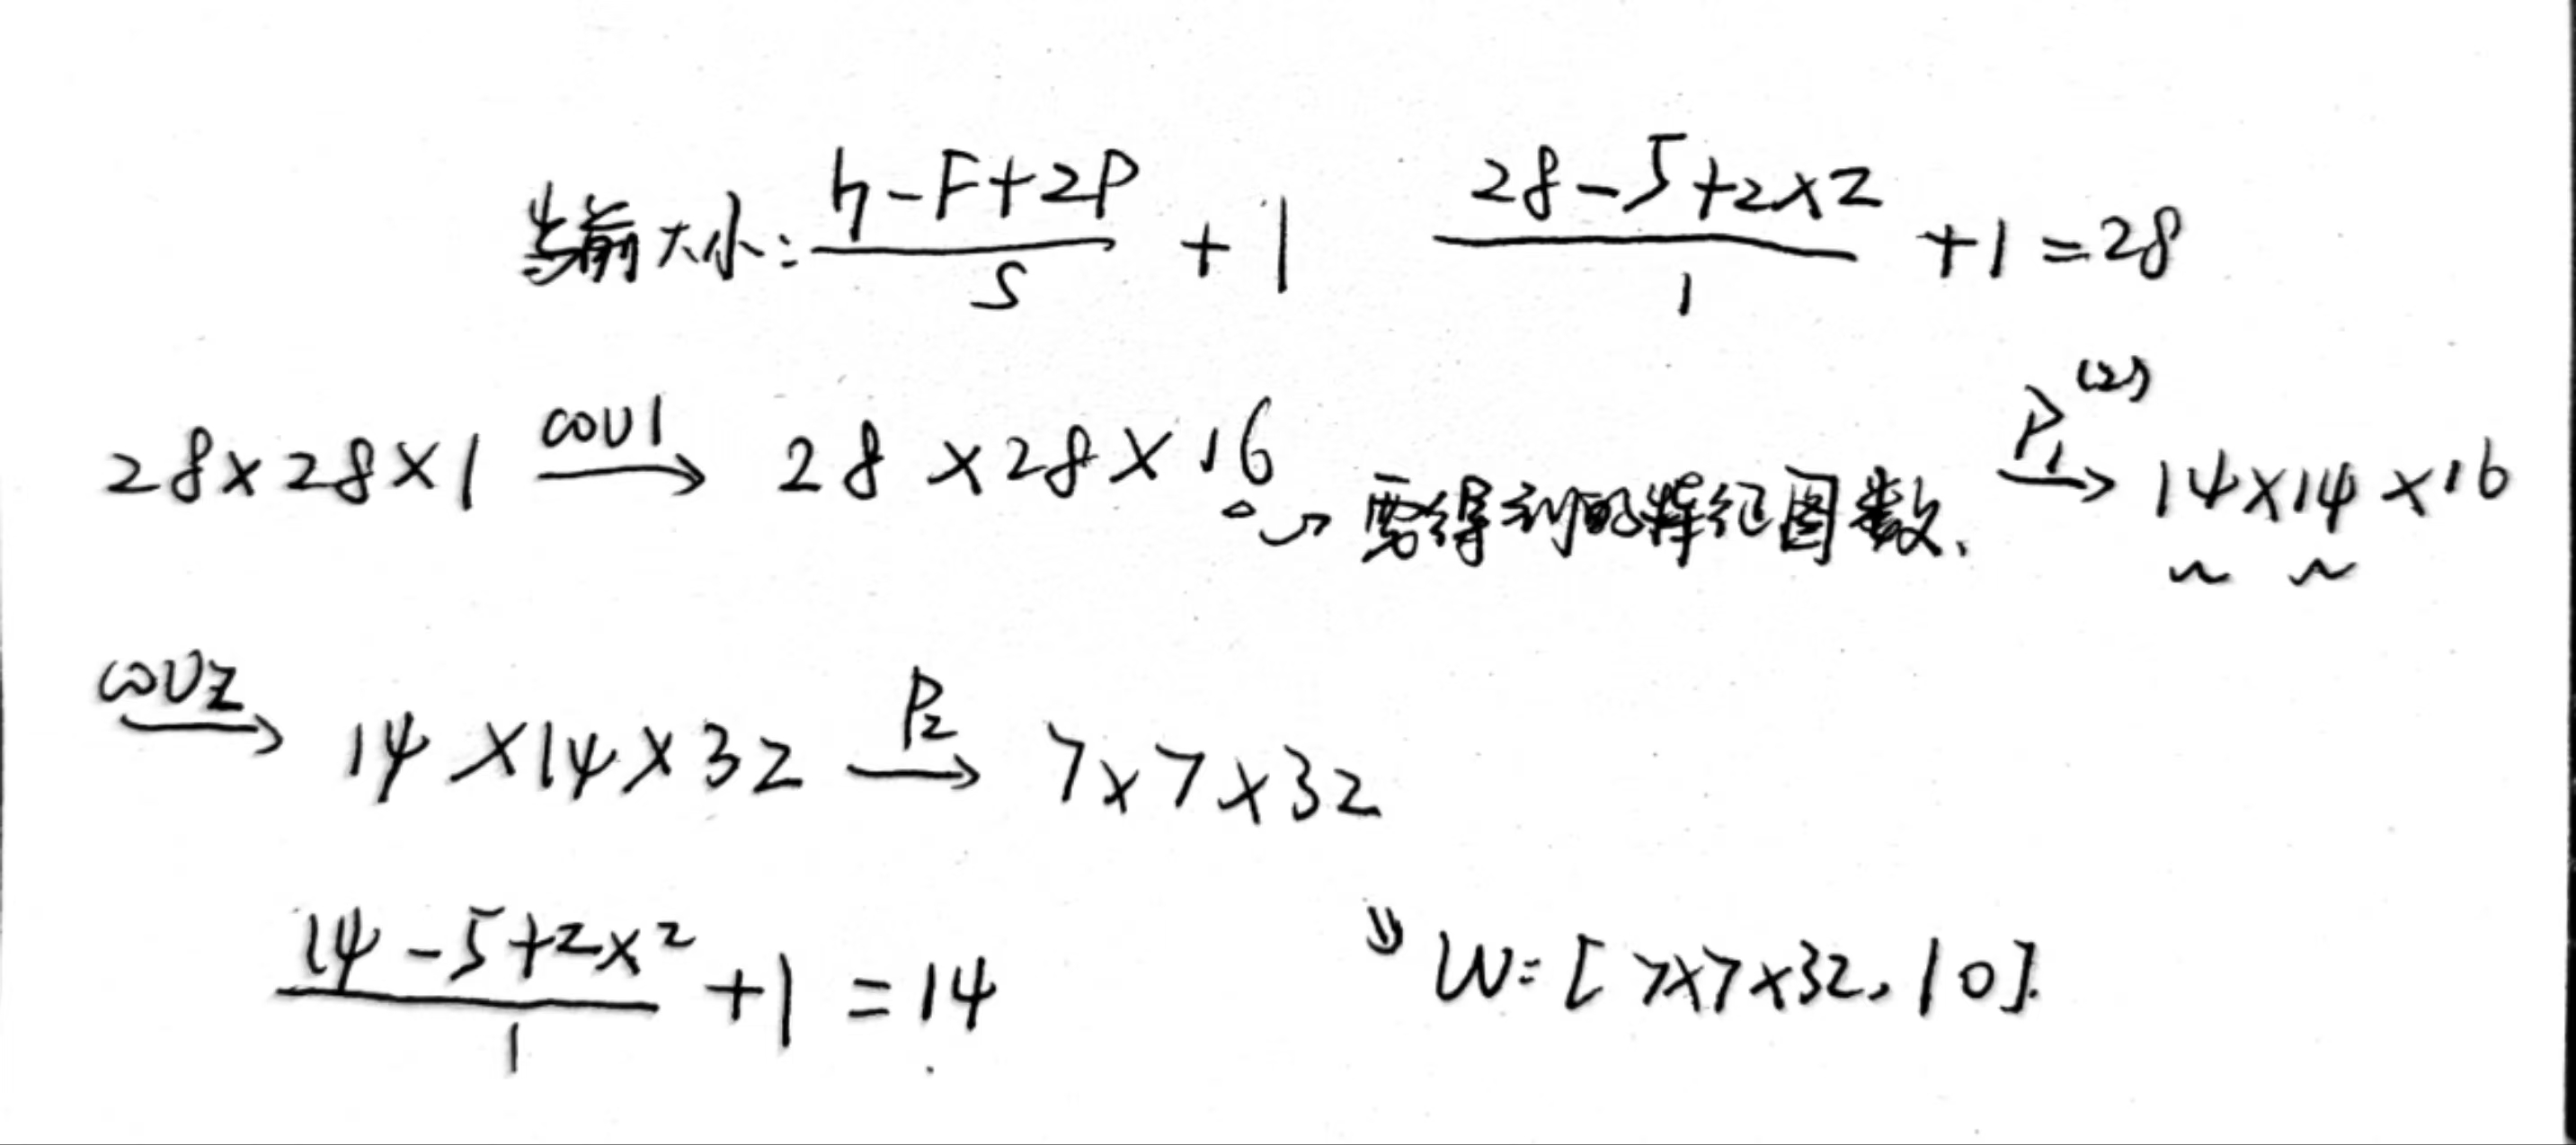

### 准确率作为评估标准

In [7]:
def accuracy(predictions, labels):
    pred = torch.max(predictions.data, 1)[1] 
    rights = pred.eq(labels.data.view_as(pred)).sum() 
    return rights, len(labels) 

### 训练网络模型

In [8]:
# 实例化
net = CNN() 
#损失函数
criterion = nn.CrossEntropyLoss() 
#优化器
optimizer = optim.Adam(net.parameters(), lr=0.001) #定义优化器，普通的随机梯度下降算法

#开始训练循环
for epoch in range(num_epochs):
    #当前epoch的结果保存下来
    train_rights = [] 
    
    for batch_idx, (data, target) in enumerate(train_loader):  #针对容器中的每一个批进行循环
        net.train()                             
        output = net(data) 
        loss = criterion(output, target) 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 
        right = accuracy(output, target) 
        train_rights.append(right) 

    
        if batch_idx % 100 == 0: 
            
            net.eval() 
            val_rights = [] 
            
            for (data, target) in test_loader:
                output = net(data) 
                right = accuracy(output, target) 
                val_rights.append(right)
                
            #准确率计算
            train_r = (sum([tup[0] for tup in train_rights]), sum([tup[1] for tup in train_rights]))
            val_r = (sum([tup[0] for tup in val_rights]), sum([tup[1] for tup in val_rights]))

            print('当前epoch: {} [{}/{} ({:.0f}%)]\t损失: {:.6f}\t训练集准确率: {:.2f}%\t测试集正确率: {:.2f}%'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), 
                loss.data, 
                100. * train_r[0].numpy() / train_r[1], 
                100. * val_r[0].numpy() / val_r[1]))

当前epoch: 0 [0/60000 (0%)]	损失: 2.302560	训练集准确率: 9.38%	测试集正确率: 25.47%
当前epoch: 0 [6400/60000 (11%)]	损失: 0.198837	训练集准确率: 77.92%	测试集正确率: 94.27%
当前epoch: 0 [12800/60000 (21%)]	损失: 0.232041	训练集准确率: 86.60%	测试集正确率: 96.89%
当前epoch: 0 [19200/60000 (32%)]	损失: 0.048790	训练集准确率: 89.88%	测试集正确率: 97.62%
当前epoch: 0 [25600/60000 (43%)]	损失: 0.036637	训练集准确率: 91.65%	测试集正确率: 97.73%
当前epoch: 0 [32000/60000 (53%)]	损失: 0.126828	训练集准确率: 92.76%	测试集正确率: 98.24%
当前epoch: 0 [38400/60000 (64%)]	损失: 0.093916	训练集准确率: 93.56%	测试集正确率: 98.45%
当前epoch: 0 [44800/60000 (75%)]	损失: 0.016935	训练集准确率: 94.18%	测试集正确率: 98.54%
当前epoch: 0 [51200/60000 (85%)]	损失: 0.114818	训练集准确率: 94.69%	测试集正确率: 98.71%
当前epoch: 0 [57600/60000 (96%)]	损失: 0.099401	训练集准确率: 95.08%	测试集正确率: 98.76%
当前epoch: 1 [0/60000 (0%)]	损失: 0.008990	训练集准确率: 100.00%	测试集正确率: 98.75%
当前epoch: 1 [6400/60000 (11%)]	损失: 0.003302	训练集准确率: 98.81%	测试集正确率: 98.53%
当前epoch: 1 [12800/60000 (21%)]	损失: 0.021696	训练集准确率: 98.59%	测试集正确率: 98.60%
当前epoch: 1 [19200/60000 (32%)]	损失: 0.016085	训练集准确率

### 代码分解与解释：

- 实例化模型：

net = CNN()：创建一个CNN模型对象，这里假设 CNN 是你自定义的卷积神经网络类。这个类定义了网络的层级结构和前向传播方法。

- 定义损失函数：

criterion = nn.CrossEntropyLoss()：选择交叉熵损失函数，通常用于多分类问题。该损失函数比较预测概率分布与真实标签的差异。

- 定义优化器：

optimizer = optim.Adam(net.parameters(), lr=0.001)：使用Adam优化器，它根据当前梯度调整每个参数的学习率，通常比传统的SGD更高效。学习率设为0.001。

- 训练循环：

for epoch in range(num_epochs)：循环进行 num_epochs 次训练，每次训练称为一个 epoch。

一个epoch：意味着算法（模型）已经使用整个训练集进行了一次训练。在一个epoch中，模型将所有的训练数据进行一次完整的遍历，计算损失，并更新模型的参数（权重）。

多个epochs：通常需要进行多个epoch训练，才能让模型充分学习数据的特征并逐步优化其性能。每经过一个epoch，模型的参数会不断更新，以减少预测错误（即损失函数的值）。

通常，训练过程中，数据会被分成多个小批次（称为 batch）。每个batch包含一定数量的样本。每次处理完一个batch，模型都会更新一次参数。一个epoch包含了所有batch的训练。

在每个epoch中，遍历训练数据（使用 train_loader）并进行训练。

- 训练过程：

for batch_idx, (data, target) in enumerate(train_loader)：按批次加载训练数据。每个批次包含输入数据 data 和对应的标签 target。

net.train()：将模型设置为训练模式，某些层如Dropout和BatchNorm在训练模式和评估模式下行为不同。

output = net(data)：将数据传入模型，得到预测结果 output。

loss = criterion(output, target)：计算损失值，即模型的输出与目标之间的差异。

optimizer.zero_grad()：清空上一步的梯度，避免梯度累积。

loss.backward()：反向传播，计算梯度。

optimizer.step()：根据计算出的梯度更新模型参数。

- 计算训练和验证准确率：

accuracy(output, target)：假设 accuracy 是一个函数，它计算模型的预测准确率。它将 output 和 target 作为输入，并返回正确预测的数量与总样本数。

- 输出训练进度和结果：

每处理100个batch，都会打印一次当前的训练损失和准确率，训练集和验证集的准确率。打印的内容包括：

当前的 epoch 和处理的进度（百分比）。

当前的损失值。

训练集和验证集的准确率（通过对正确预测数量和总样本数量进行计算）。

- 其他说明：

准确率计算： 训练和验证集的准确率是通过 train_rights 和 val_rights 中的正确定义计算的，它们存储每个batch的预测结果。每个batch的 accuracy 返回的是一个包含两部分的元组，第一个部分是正确预测的数量，第二个部分是样本的总数。然后，你可以通过总的正确预测数和总样本数来计算准确率。

torch 和 numpy 的转换： 注意你在计算训练和验证准确率时，使用了 .numpy()，这通常是因为 train_rights 和 val_rights 中存储的是 torch.Tensor 类型的数据，而你需要将其转换为 numpy 数组来进行操作。

### 练习
- 再加入一层卷积，效果怎么样？
- 当前任务中为什么全连接层是32*7*7 其中每一个数字代表什么含义